In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import fmin_l_bfgs_b
from sklearn.datasets.samples_generator import make_blobs
from scipy.linalg import cholesky, cho_solve, solve_triangular

### Create fake dataset

In [2]:
# create fake dataset
X_data, y_data = make_blobs(n_samples=50, centers=2, n_features=3, random_state=10) # 26
y_data[y_data==0] = -1

y_data = y_data.reshape(-1,1)

In [3]:
# number of dimension
D = X_data.shape[1]

In [5]:
X = X_data[:25,:]
y = y_data[:25]

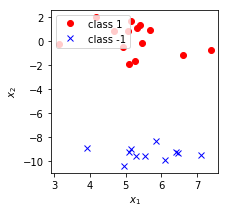

In [6]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(X[y.flatten()==1][:, 0], X[y.flatten()==1][:,1], 'ro', label='class 1')
ax.plot(X[y.flatten()==-1][:, 0], X[y.flatten()==-1][:,1], 'bx', label = 'class -1')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_xlim(-10, 10)
#ax.set_ylim(-5, 15)
ax.legend(loc='upper left')
plt.show()

#### Kernels

We squared exponential kerne (a.k.a RBF) with hyperparameter $l$:
$$ K(x_i, x_j) = \exp \Big(\frac{-|| x_i - x_j ||^2}{2l^2} \Big) $$

In [69]:
def exp_kernel(a, b, theta_):
    # theta includes number of parameters
    squared_dist = np.linalg.norm(a-b)**2
    
    k = np.exp(-squared_dist/(2*theta_[0]**2))
    k_gradient = squared_dist/(2*theta_[0]**3)*k
    return k

In [ ]:

from scipy.spatial.distance import pdist, squareform

In [113]:
%%time
# this is an NxD matrix, where N is number of items and D its dimensionalites
pairwise_dists = squareform(pdist(Z, 'euclidean'))
K2 = np.exp(-pairwise_dists ** 2 / 2 ** 2)

CPU times: user 103 µs, sys: 6 µs, total: 109 µs
Wall time: 92.5 µs


In [114]:
pairwise_dists

array([[0.        , 2.82842712, 5.65685425],
       [2.82842712, 0.        , 2.82842712],
       [5.65685425, 2.82842712, 0.        ]])

In [76]:
K2

array([[1.00000000e+00, 1.35335283e-01, 3.35462628e-04],
       [1.35335283e-01, 1.00000000e+00, 1.35335283e-01],
       [3.35462628e-04, 1.35335283e-01, 1.00000000e+00]])

In [106]:
%%time
K= pairwise_kernels(Z, metric=exp_kernel,  theta_= [2])

CPU times: user 573 µs, sys: 0 ns, total: 573 µs
Wall time: 347 µs


In [72]:
K

array([[1.        , 0.36787944, 0.01831564],
       [0.36787944, 1.        , 0.36787944],
       [0.01831564, 0.36787944, 1.        ]])

In [61]:
Z = np.array([[1,2], [3,4], [5,6]])

In [10]:
kernel_type = 'exp_kernel' # 'ard_kernel' 'recursive_kernel' 'ard_exp_kernel'

#### Optimization

We need find paramaters of kernel, in our case it's $l$ to maximize log marginal likelihood.

$$ \mathcal{L} = \log p(\mathbf{y}|X) = -\frac{1}{2} \mathbf{y}^T \mathbf{\alpha} - \sum_{i}^{N}L_{ii} - \frac{N}{2} \log(2 \pi) $$

In [11]:
y.shape

(25, 1)

In [12]:
sigma_n_square = 1e-10

In [13]:
# choose boundaries for optimazation
LOCAL_BOUND = (1e-2, 1e2)
bounds = []
if kernel_type == 'exp_kernel':
    bounds.append(LOCAL_BOUND)
    x0 = np.ones(1) # only one value is optimized
    kernel_func = exp_kernel
else:
    x0 = np.ones(X.shape[1])*10 # all dimension
    kernel_func = ard_exp_kernel
    for i in range(X.shape[1]):
        bounds.append(LOCAL_BOUND)
    if kernel_type == 'recursive_kernel':
        bounds.append(LOCAL_BOUND)
        x0 = np.ones(X.shape[1] + 1)*10 # rho added
        kernel_func = recursive_kernel

In [15]:
def log_marginal_likelihood(theta_, *args):
    #print(kernel_func)
    
    K = pairwise_kernels(X, metric=exp_kernel,  theta_=theta_)

    # do Cholesky decomposition
    L = cholesky(K + sigma_n_square*np.eye(len(X)), lower=True)
    #print(L)
    # solve for alpha
    alpha = cho_solve(  (L, True), y )
   # alpha = np.linalg.solve( L.T, np.linalg.solve(L, y) )
    return -( -0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi) )

In [16]:
def optimize_kernel_parameters(x0):
    #x0 = np.array([1])
    
    #bounds =  ((1e-2, 1e2),(1e-2, 1e2),)
    theta_estimate, min_log_marginal_likelihood, info = fmin_l_bfgs_b(func=log_marginal_likelihood, x0 = x0, args=(),  approx_grad=True, bounds=bounds)
    print('Optimization succeded with log marginal likelihood ', min_log_marginal_likelihood[0][0], ' in ', info['funcalls'],' iterations.')
    return  theta_estimate, min_log_marginal_likelihood, info

In [17]:
OPTIMIZATION_ITERATIONS = 10

In [18]:
%%time
log_likelihood_list = []
theta_est_list  = []
for i in range(OPTIMIZATION_ITERATIONS):
    bounds = np.array(bounds)
    theta_initial = np.random.uniform(bounds[:, 0], bounds[:, 1])
    theta_estimate, min_log_marginal_likelihood, info = optimize_kernel_parameters(x0)
    log_likelihood_list.append(min_log_marginal_likelihood[0][0])
    theta_est_list.append(theta_estimate)

Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
Optimization succeded with log marginal likelihood  -43.6235041973781  in  36  iterations.
CPU times: user 818 ms, sys: 24.6 ms, total: 842 ms
Wall time: 802 ms


In [19]:
theta_estimate[np.argmin(log_likelihood_list)]

5.9202415604433964

In [21]:
info

{'grad': array([-0.0126974]),
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 36,
 'nit': 6,
 'warnflag': 0}

In [22]:
theta_estimate

array([5.92024156])

In [23]:
# make prediction
def predict(x_star, theta):

    # create covariance matrix using kernel
    K = pairwise_kernels(X, metric=kernel_func,  theta_=theta)

    # do Cholesky decomposition
    L = cholesky(K + sigma_n_square*np.eye(X.shape[0]), lower=True)

    # solve for alpha
    alpha = cho_solve(    (L, True),    y   )
    
    L_inv = solve_triangular(L.T, np.eye(L.shape[0]))
    K_inv = L_inv.dot(L_inv.T)

    k_star = pairwise_kernels(x_star, X, metric=kernel_func,  theta_= theta)
    y_mean = k_star.dot(alpha) + np.mean(y)
    y_var = np.ones(x_star.shape[0]) - np.einsum("ij,ij->i", np.dot(k_star, K_inv), k_star)
    y_var[y_var < 0] = 0

    # log marginal likelihood
    log_marg_likelihood = -0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi)
    
    #print(-0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi))
    return y_mean, np.sqrt(y_var), log_marg_likelihood

In [25]:
y_pred, y_sigma, y_log_lh = predict(X_data[26:28,:], theta_estimate)

In [27]:
y_sigma, sigma2

NameError: name 'sigma2' is not defined

In [28]:
y_log_lh

array([[43.6235042]])

In [29]:
y_pred

array([[1.11437784],
       [1.12007304]])

In [30]:
y_sigma

array([0.01853789, 0.00898013])

In [31]:
y_data[26:28]

array([[1],
       [1]])

In [32]:
1/np.sqrt(2*np.pi*y_sigma[0]**2)*np.exp( - (y_pred[0] - 1)**2 / (2*y_sigma[0]**2) )

array([1.16527088e-07])

Gaussian distribution
$$ p(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2} } \exp \Big( - \frac{(x-\mu)^2}{2\sigma^2} \Big) $$

In [33]:
y_data[26:40].faltten()

AttributeError: 'numpy.ndarray' object has no attribute 'faltten'

In [34]:
def gaussian_pdf(x_, mu_, sigma_):
    # sigma_[sigma_ == 0] = 1e-2
    #print(y_pred.shape, mu_.shape)
    #print(- (x_ - mu_)**2)
    return  np.exp( - (x_ - mu_)**2 / (2 * sigma_**2) )* 1/ ( np.sqrt(2*np.pi) * sigma_)
#    # return 1/ ( np.sqrt(2*np.pi) * sigma_) * np.exp( - (x_ - mu_)**2 / (2 * sigma_**2) )

In [36]:
y_data[26:28].flatten()

array([1, 1])

In [37]:
gaussian_pdf(y_pred.flatten(), y_data[26:28].flatten(), y_sigma)

array([1.16527088e-07, 6.68949656e-38])

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [39]:
# Instantiate a Gaussian Process model
kernel = RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=sigma_n_square)

In [40]:
%%time
# train GP model
gp.fit(X, y.flatten())

CPU times: user 61.2 ms, sys: 0 ns, total: 61.2 ms
Wall time: 60.2 ms


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [41]:
1/1.78*2

1.1235955056179776

In [42]:
gp.kernel_.theta

array([1.77846856])

In [43]:
gp.log_marginal_likelihood_value_

43.623505887458805

In [44]:
y_pred2, sigma2 = gp.predict(X=X_data[26:28,:], return_std=True)

In [45]:
y_pred2

array([0.994379  , 1.00007343])

In [46]:
sigma2

array([0.01853228, 0.00897742])

In [47]:
gaussian_pdf(x_ = y_pred2[2], mu_= -1, sigma_=sigma2[2] )

IndexError: index 2 is out of bounds for axis 0 with size 2

In [48]:
gaussian_pdf(x_= y_pred2 , mu_= y_data[26:40].flatten(), sigma_=sigma2)

ValueError: operands could not be broadcast together with shapes (2,) (14,) 

In [56]:
gp.kernel_

RBF(length_scale=5.92)

In [50]:
y_pred2, y_pred

(array([0.994379  , 1.00007343]), array([[1.11437784],
        [1.12007304]]))

In [119]:
sigma2, y_sigma

(array([0.00000000e+00, 2.97069159e-05]), array([0., 0.]))